## Table of Content
### Exploratory Data Analysis
* [0. Importing Libraries](#c0)
* [1. Loading Original Datasets](#c1)
* [2. Exploration and data cleaning](#c2)
    * [2.1 Understanding the features](#s21)
    * [2.2 Identifying Duplicated and Null Values](#s22)
    * [2.3 Handling Null Values and Removing Irrelevant Information](#s23)
        * [2.3.1 Using KNN to predict geolocation columns (propertycountylandusecode regionidcity, regionidzip, etc.)](#s231)
* [3. Univariate Analysis](#c3)
    * [3.1 Dividing our dataset into categorial and numerical.](#s31)
    * [3.2 Categorical Variable Analysis](#s32) 
* [4. Multivariate Analysis](#c4)
    * [4.1 Encoding Categorical Values and Saving JSON files](#s41)
    * [4.2 Numerical-Categorical Analysis (Correlation Analysis)](#s42)
* [5. Feature Engineering](#c5)
    * [5.1 New feature Inference](#s51)
    * [5.2 Outlier Analysis](#s52)
* [6. Data Processing](#c6)
    * [6.1 Feature Selection based on Importance](#s61)
    * [6.2 Split train/test](#s62)
    * [6.3 Saving Data Frames into CSV files](#s63)
### Machine Learning 
* [7.1 Decision Making: What's the best model?](#s71)
* [7.2 Model Optimization](#s72)
    * [7.2.1 LightGBM Optimization](#s721)
    * [7.2.2 Ensemble Optimization](#s722) 

## Exploratory Data Analysis (EDA)
### 0. Importing Libraries <a class="anchor" id="c0"></a>

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

import requests
import urllib
from io import StringIO
from concurrent.futures import ThreadPoolExecutor

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

### 1. Loading Original Datasets <a class="anchor" id="c1"></a>

In [5]:
df2016 = pd.read_csv('../data/raw/properties_2016.csv')
df2016.head(3)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN


In [5]:
train16 = pd.read_csv('../data/raw/train_2016_v2.csv')
train16['transactiondate'] = pd.to_datetime(train16['transactiondate'])
train16['transaction_month'] = train16['transactiondate'].dt.month
train16['transaction_year'] = train16['transactiondate'].dt.year
train16['transaction_day'] = train16['transactiondate'].dt.day
train16['transaction_dayofweek'] = train16['transactiondate'].dt.dayofweek
train16 = train16.drop(columns='transactiondate')
train16.head(3)

,parcelid,logerror,transaction_month,transaction_year,transaction_day,transaction_dayofweek
0,11016594,0.0276,1,2016,1,4
1,14366692,-0.1684,1,2016,1,4
2,12098116,-0.0040,1,2016,1,4


### 2. Exploration and data cleaning <a class="anchor" id="c2"></a>
#### 2.1 Understanding the dataset <a id="s21"></a>

In [8]:
df2016.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   parcelid                      2985217 non-null  int64  
 1   airconditioningtypeid         811519 non-null   float64
 2   architecturalstyletypeid      6061 non-null     float64
 3   basementsqft                  1628 non-null     float64
 4   bathroomcnt                   2973755 non-null  float64
 5   bedroomcnt                    2973767 non-null  float64
 6   buildingclasstypeid           12629 non-null    float64
 7   buildingqualitytypeid         1938488 non-null  float64
 8   calculatedbathnbr             2856305 non-null  float64
 9   decktypeid                    17096 non-null    float64
 10  finishedfloor1squarefeet      202717 non-null   float64
 11  calculatedfinishedsquarefeet  2929652 non-null  float64
 12  finishedsquarefeet12        

| Feature                         | Description                                                                                  |
|---------------------------------|----------------------------------------------------------------------------------------------|
| airconditioningtypeid           | Type of cooling system present in the home (if any).                                         |
| architecturalstyletypeid        | Architectural style of the home (e.g., ranch, colonial, split-level, etc.).                  |
| basementsqft                    | Finished living area below or partially below ground level.                                  |
| bathroomcnt                     | Number of bathrooms in home including fractional bathrooms.                                  |
| bedroomcnt                      | Number of bedrooms in home.                                                                 |
| buildingqualitytypeid           | Overall assessment of condition of the building from best (lowest) to worst (highest).       |
| buildingclasstypeid             | The building framing type (steel frame, wood frame, concrete/brick).                        |
| calculatedbathnbr               | Number of bathrooms in home including fractional bathrooms.                                  |
| decktypeid                      | Type of deck (if any) present on parcel.                                                    |
| threequarterbathnbr             | Number of 3/4 bathrooms in house (shower + sink + toilet).                                   |
| finishedfloor1squarefeet        | Size of the finished living area on the first (entry) floor of the home.                     |
| calculatedfinishedsquarefeet    | Calculated total finished living area of the home.                                          |
| finishedsquarefeet12            | Base unfinished and finished area.                                                          |
| finishedsquarefeet13            | Perimeter living area.                                                                      |
| finishedsquarefeet15            | Finished living area.                                                                       |
| finishedsquarefeet50            | Size of the finished living area on the first (entry) floor of the home.                    |
| fips                            | Federal Information Processing Standard code (county code).                                 |
| fireplacecnt                    | Number of fireplaces in the home (if any).                                                 |
| fireplaceflag                   | Is a fireplace present in this home.                                                       |
| fullbathcnt                     | Number of full bathrooms (sink, shower + bathtub, and toilet) present in home.              |
| garagecarcnt                    | Total number of garages on the lot not including an attached garage.                        |
| garagetotalsqft                 | Total number of square feet of all garages on lot including an attached garage.             |
| hashottuborspa                  | Does the home have a hot tub or spa.                                                        |
| heatingorsystemtypeid           | Type of home heating system.                                                                |
| latitude                        | Latitude of the middle of the parcel multiplied by 10e6.                                    |
| longitude                       | Longitude of the middle of the parcel multiplied by 10e6.                                   |
| lotsizesquarefeet               | Area of the lot in square feet.                                                             |
| numberofstories                 | Number of stories or levels the home has.                                                  |
| parcelid                        | Unique identifier for parcels (lots).                                                      |
| poolcnt                         | Number of pools on the lot (if any).                                                       |
| poolsizesum                     | Total square footage of all pools on property.                                             |
| pooltypeid10                    | Spa or Hot Tub.                                                                             |
| pooltypeid2                     | Pool with Spa/Hot Tub.                                                                      |
| pooltypeid7                     | Pool without Hot Tub.                                                                       |
| propertycountylandusecode       | County land use code i.e. zoning at the county level.                                       |
| propertylandusetypeid           | Type of land use the property is zoned for.                                                |
| propertyzoningdesc              | Description of the allowed land uses (zoning) for that property.                           |
| censustractandblock             | Census tract and block ID combined - also contains blockgroup assignment by extension.      |
| rawcensustractandblock          | Census tract and block ID combined - also contains blockgroup assignment.                  |
| regionidcounty                  | County in which the property is located.                                                   |
| regionidcity                    | City in which the property is located (if any).                                            |
| regionidzip                     | Zip code in which the property is located.                                                 |
| regionidneighborhood            | Neighborhood in which the property is located.                                             |
| roomcnt                         | Total number of rooms in the principal residence.                                           |
| storytypeid                     | Type of floors in a multi-story house (e.g., basement and main level, split-level, etc.).   |
| typeconstructiontypeid          | What type of construction material was used to construct the home.                         |
| unitcnt                         | The number of units the structure is built into (e.g., 2 = duplex, 3 = triplex, etc.).      |
| yardbuildingsqft17              | Storage shed/building in yard.                                                             |
| yardbuildingsqft26              | The total tax assessed value of the parcel.                                                |
| yearbuilt                       | The year the principal residence was built.                                                |
| structuretaxvaluedollarcnt      | The assessed value of the built structure on the parcel.                                    |
| landtaxvaluedollarcnt           | The land value of the land area of the parcel.                                             |
| taxvaluedollarcnt               | The total property tax assessed for that assessment year.                                   |
| assessmentyear                  | The year of the property tax assessment.                                                   |
| taxamount                       | The total property tax assessed as of 2015.                                                |
| taxdelinquencyflag              | Property taxes for this parcel are past due.                                               |
| taxdelinquencyyear              | Year for which the taxes are past due.                                                     |


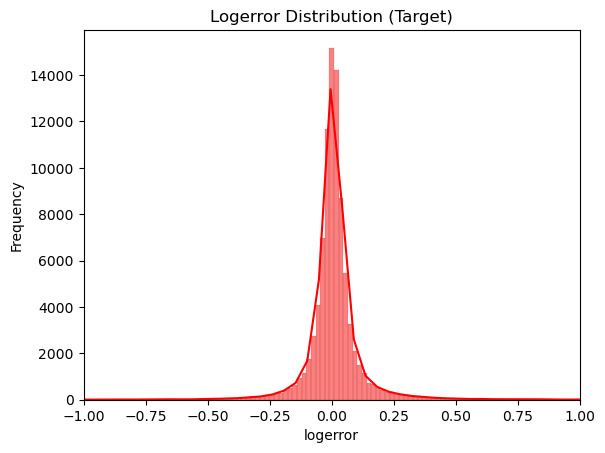

In [10]:
# Check the the target distribution
sns.histplot(data=train16['logerror'], bins=500, kde=True, color='red')
plt.xlim(-1, 1)
plt.title('Logerror Distribution (Target)')
plt.xlabel('logerror')
plt.ylabel('Frequency')
plt.show()

#### 2.2 Identifying Duplicated and Null Values <a id="s22"></a>

In [12]:
# Checking how many duplicated values we have in our DataFrame. 
df2016.duplicated().sum()

0

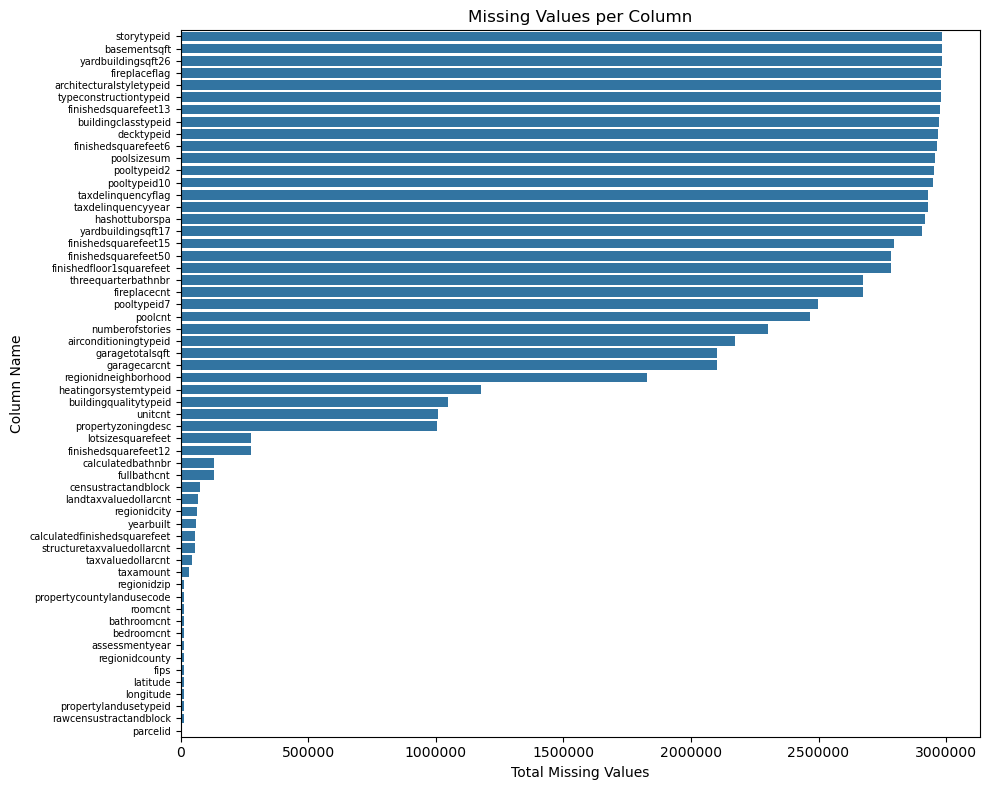

In [13]:
from matplotlib.ticker import FuncFormatter

# Checking how many null values we have per columns in our DataFrame
missing = df2016.isnull().sum().reset_index()
missing.columns = ['columnname', 'count']
missing = missing.sort_values('count', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='count', y='columnname', data=missing)
plt.title('Missing Values per Column')
plt.ylabel('Column Name')
plt.yticks(fontsize=7, fontweight='light')
plt.xlabel('Total Missing Values')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


#### 2.3 Handling Null Values and Removing Irrelevant Information <a id="s23"></a>

In [15]:
# Columns representing areas in square meters (sqm), where NaN indicates the absence of that feature.
sqm_columns = ['basementsqft', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 
               'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'poolsizesum', 'garagetotalsqft', 
               'yardbuildingsqft17', 'yardbuildingsqft26']

df2016[sqm_columns] = df2016[sqm_columns].fillna(0)

In [16]:
# Columns representing counts (e.g., number of rooms, pools), where NaN indicates the absence of the feature.
count_columns = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'numberofstories', 'poolcnt', 
                 'roomcnt', 'threequarterbathnbr', 'unitcnt'] 

df2016[count_columns] = df2016[count_columns].fillna(0)

In [17]:
# Boolean columns where the presence of a feature was not explicitly marked as False. Converting these columns to binary 
# format: 1 for positive and 0 for negative.
df2016['hashottuborspa'] = df2016['hashottuborspa'].apply(lambda x: 1 if x==True else 0)
df2016['fireplaceflag'] = df2016['fireplaceflag'].apply(lambda x: 1 if x==True else 0)
df2016['taxdelinquencyflag'] = df2016['taxdelinquencyflag'].apply(lambda x: 1 if x=='Y' else 0)

In [18]:
# Removing rows with missing location data - 'location' columns are essential for identifying properties geographically. 
# Rows with all null values in these columns are dropped (11,437 rows removed, which represents ~0.40% of the dataset).
location = ['regionidzip', 'fips', 'regionidcounty', 'longitude', 'latitude', 'censustractandblock', 'propertyzoningdesc', 
                'rawcensustractandblock', 'regionidcity']
no_loc_index = df2016[df2016[location].isna().all(axis=1)].index

df2016 = df2016.drop(df2016.index[no_loc_index])

In [19]:
# For properties where 'poolcnt' is 0 (indicating no pools are present), all related columns, such as pool size and pool types, 
# should be filled with zero. 
pool_related = ['poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

df2016.loc[df2016['poolcnt'] == 0, pool_related] = 0

In [20]:
# Validating that the 'pool_types' columns correctly represent pool features across all rows. If 'pooldif' is 0 (indicating no diference), 
# all related pool columns can safely be filled with 0
pool_types = ['pooltypeid10', 'pooltypeid2', 'pooltypeid7']
df2016['poolcount2'] = df2016[pool_types].sum(axis=1)
df2016['pooldif'] = df2016['poolcnt'] - df2016['poolcount2']
df2016[df2016['pooldif']!=0]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,poolcount2,pooldif


In [21]:
# Filling up all columns within 'pool_types' list and dropping previously created columns 
df2016[pool_types] = df2016[pool_types].fillna(0)
new_cols = ['poolcount2', 'pooldif']
df2016 = df2016.drop(columns=new_cols)

In [22]:
# Columns representing Null as non existent (Assumption)
non_existent = ['airconditioningtypeid', 'decktypeid', 'heatingorsystemtypeid', 'taxdelinquencyyear']
df2016[non_existent] = df2016[non_existent].fillna(0)

In [23]:
# Correcting scales for geoloc columsn (lat & lon)
df2016['latitude'], df2016['longitude'] = df2016['latitude']/(10**6), df2016['longitude']/(10**6)
df2016.head(3)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6037.0,0.0,0.0,0.0,0.0,0,0.0,34.144442,-118.654084,85768.0,0.0,0.0,0.0,0.0,0.0,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0,NaN,9.0,2015.0,9.0,NaN,0,0.0,NaN
1,10759547,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6037.0,0.0,0.0,0.0,0.0,0,0.0,34.140430,-118.625364,4083.0,0.0,0.0,0.0,0.0,0.0,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0,NaN,27516.0,2015.0,27516.0,NaN,0,0.0,NaN
2,10843547,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,73026.0,0.0,0.0,73026.0,0.0,0.0,6037.0,0.0,0.0,0.0,0.0,0,0.0,33.989359,-118.394633,63085.0,0.0,0.0,0.0,0.0,0.0,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,0.0,NaN,2.0,0.0,0.0,NaN,0.0,0,650756.0,1413387.0,2015.0,762631.0,20800.37,0,0.0,NaN


In [24]:
# Function to get missing 'censustractandblock'
def getcensustractandblock(lat, lon):
    try: 
        params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
        url = 'https://geo.fcc.gov/api/census/block/find?' + params
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data['Block']['FIPS']
        else: 
            print(f'Error: Received status code {response.status_code} for lat: {lat}, lon: {lon}')
    except Exception as e: 
        print(f'Error fetching info for lat: {lat}, lon {lon}')

def process_row(lat, lon):
    return getcensustractandblock(lat, lon)

coords_to_process = df2016[df2016['censustractandblock'].isnull()][['latitude', 'longitude']].drop_duplicates()

coord_to_fips = {}

# Parallel process -> Do not change the max_workers to more than 500, otherwise the page url won't work. 
with ThreadPoolExecutor(max_workers=500) as executor:
    results = executor.map(lambda row: (row['latitude'], row['longitude'], process_row(row['latitude'], row['longitude'])),
                           coords_to_process.to_dict(orient='records'))

    for lat, lon, fips in results:
        coord_to_fips[(lat, lon)] = fips

df2016['censustractandblock'] = df2016.apply(lambda row: coord_to_fips.get((row['latitude'], row['longitude']), row['censustractandblock']), axis=1)

In [25]:
df2016['censustractandblock'] = df2016['censustractandblock'].astype('int64')

In [26]:
df2016.to_csv('../data/processed/df_with_censustract.csv', index=False)

##### 2.3.1 Using KNN to predict geolocation columns (propertycountylandusecode regionidcity, regionidzip, etc.) <a id="s231"></a>

In [107]:
# Preparing lat and lon for our KNN model
data = df2016[['latitude', 'longitude']]
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
df2016[['lat_scaled', 'long_scaled']] = scaled

##### 2.3.1.1 regionidcity

In [31]:
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['lat_scaled', 'long_scaled', 'regionidcity'])
test_data = df2016[df2016['regionidcity'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled']]
y_train = train_data['regionidcity']
X_test = test_data[['lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [32]:
# Initial prediction of best_params_ = 10 -> params tested [5, 10, 15, 20, 25]
params={'n_neighbors': [8, 9, 10, 11, 12]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 9


In [33]:
model=KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'regionidcity': {accuracy * 100:.2f}%")

KNN Accuracy for 'regionidcity': 99.68%


In [34]:
df2016.loc[df2016['regionidcity'].isnull(), 'regionidcity'] = model.predict(X_test)

In [35]:
# Verify that there are no missing values left in the 'regionidcity' column
df2016['regionidcity'].isnull().sum()

0

-------------------------

##### 2.3.1.2 propertycountylandusecode

In [108]:
# propertycountylandusecode
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['propertycountylandusecode', 'lat_scaled', 'long_scaled', 'regionidcity', 'regionidcounty'])
test_data = df2016[df2016['propertycountylandusecode'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled', 'regionidcity', 'regionidcounty']]
y_train = train_data['propertycountylandusecode']
X_test = test_data[['lat_scaled', 'long_scaled', 'regionidcity', 'regionidcounty']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [39]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
params={'n_neighbors': [3, 4, 5, 6, 7]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 4


In [106]:
model=KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertycountylandusecode': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertycountylandusecode': 82.96%


In [114]:
df2016.loc[df2016['propertycountylandusecode'].isnull(), 'propertycountylandusecode'] = model.predict(X_test)

In [116]:
# Verify that there are no missing values left in the 'propertycountylandusecode' column
df2016['propertycountylandusecode'].isnull().sum()

0

-------------------------

##### 2.3.1.3 regionidzip

In [120]:
# regionidzip
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['regionidzip', 'lat_scaled', 'long_scaled'])
test_data = df2016[df2016['regionidzip'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled',]]
y_train = train_data['regionidzip']
X_test = test_data[['lat_scaled', 'long_scaled',]]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [121]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
# Second prediction of best_params_ = 3 -> params tested [3, 4, 5, 6, 7]
params={'n_neighbors': [1, 2, 3, 4, 5]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 1


In [122]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'regionidzip': {accuracy * 100:.2f}%")

KNN Accuracy for 'regionidzip': 99.75%


In [123]:
df2016.loc[df2016['regionidzip'].isnull(), 'regionidzip'] = model.predict(X_test)

In [125]:
# Verify that there are no missing values left in the 'regionidzip' column
df2016['regionidzip'].isnull().sum()

0

-------------------------

##### 2.3.1.4 propertyzoningdesc

In [128]:
df2016['propertyzoningdesc'] = df2016['propertyzoningdesc'].apply(lambda x: str(x) if pd.notnull(x) else x)
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['lat_scaled', 'long_scaled', 'propertyzoningdesc'])
test_data = df2016[df2016['propertyzoningdesc'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled']]
y_train = train_data['propertyzoningdesc']
X_test = test_data[['lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [129]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
# Second prediction of best_params_ = 3 -> params tested [3, 4, 5, 6, 7]
params={'n_neighbors': [1, 2, 3, 4, 5]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 1


In [130]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertyzoningdesc': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertyzoningdesc': 90.25%


In [131]:
df2016.loc[df2016['propertyzoningdesc'].isnull(), 'propertyzoningdesc'] = model.predict(X_test)

-------------------------

##### 2.3.1.5 regionidneighborhood

In [134]:
# regionidneighborhood
# df2016['regionidneighborhood'] = df2016['regionidneighborhood'].apply(lambda x: str(x) if pd.notnull(x) else x)

# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['fips', 'lat_scaled', 'long_scaled', 'regionidneighborhood'])
test_data = df2016[df2016['regionidneighborhood'].isnull()]

X_train = train_data[['fips', 'lat_scaled', 'long_scaled']]
y_train = train_data['regionidneighborhood']
X_test = test_data[['fips', 'lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [135]:
# Initial prediction of best_params_ = 5 -> params tested [5, 10, 15, 20, 25]
# Second prediction of best_params_ = 3 -> params tested [3, 4, 5, 6, 7]
params={'n_neighbors': [1, 2, 3, 4, 5]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 1


In [136]:
model=KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertyzoningdesc': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertyzoningdesc': 99.45%


In [137]:
df2016.loc[df2016['regionidneighborhood'].isnull(), 'regionidneighborhood'] = model.predict(X_test)

In [138]:
# Verify that there are no missing values left in the 'regionidneighborhood' column
df2016['regionidneighborhood'].isnull().sum()

0

-------------------------

##### 2.3.1.6 buildingqualitytypeid

In [141]:
# buildingqualitytypeid -> Assuming the nearest buildings have the same quality type. 
# Creating a train and a test set (train is no null values while test will be the null values where we want to predict. )
train_data = df2016.dropna(subset=['lat_scaled', 'long_scaled', 'buildingqualitytypeid'])
test_data = df2016[df2016['buildingqualitytypeid'].isnull()]

X_train = train_data[['lat_scaled', 'long_scaled']]
y_train = train_data['buildingqualitytypeid']
X_test = test_data[['lat_scaled', 'long_scaled']]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [142]:
# Initial prediction of best_params_
params={'n_neighbors': [3, 4, 5, 6, 7]}
grid=GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_['n_neighbors']}")

Best params: 5


In [143]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
accuracy=model.score(X_val, y_val)
print(f"KNN Accuracy for 'propertyzoningdesc': {accuracy * 100:.2f}%")

KNN Accuracy for 'propertyzoningdesc': 88.38%


In [144]:
df2016.loc[df2016['buildingqualitytypeid'].isnull(), 'buildingqualitytypeid'] = model.predict(X_test)

In [145]:
# Verify that there are no missing values left in the 'regionidneighborhood' column
df2016['buildingqualitytypeid'].isnull().sum()

0

In [146]:
# Identifying columns with higher nulls than the threshold (null_cap = 50%) and dropping them. 
null_cap = 0.95
cols_maxcap = []

for col in df2016.columns:
    if ((df2016[col].isna().sum())/len(df2016)) > null_cap:
        cols_maxcap.append(col)

df2016 = df2016.drop(columns=cols_maxcap).reset_index(drop=True)


In [148]:
# Dropping the rows where there are still nulls 
null_cols = df2016.isna().sum()[df2016.isna().sum()>0].index.to_list()
df = df2016.dropna(subset=null_cols)
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

-----------------------------------------------------

In [170]:
df2016.to_csv('../data/processed/df2016_fullyprocessed.csv', index=False)

-----------------------------------------------------

In [97]:
df2016 = pd.read_csv('../data/processed/df2016_fullyprocessed.csv')

In [98]:
df_merged = train16.merge(df2016, on='parcelid', how='left')
df_merged.head(3)

,parcelid,logerror,transaction_month,transaction_year,transaction_day,transaction_dayofweek,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,lat_scaled,long_scaled,regionidcity_scaled,regionidcountry_scaled,fips_scaled
0,11016594,0.0276,1,2016,1,4,1.0,0.0,2.0,3.0,4.0,2.0,0.0,0.0,1684.0,1684.0,0.0,0.0,0.0,0.0,6037.0,0.0,2.0,0.0,0.0,0,2.0,34.280990,-118.488536,7528.0,0.0,0.0,0.0,0.0,0.0,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,0.0,1.0,0.0,0.0,1959.0,0.0,0,122754.0,360170.0,2015.0,237416.0,6735.88,0,0.0,60371066461001,1.148492,-0.829967,-0.444460,0.673213,-0.545234
1,14366692,-0.1684,1,2016,1,4,0.0,0.0,3.5,4.0,4.0,3.5,0.0,0.0,2263.0,2263.0,0.0,0.0,0.0,0.0,6059.0,0.0,3.0,2.0,468.0,0,0.0,33.668120,-117.677556,3643.0,0.0,0.0,0.0,0.0,0.0,1,261.0,LBPD1,6.059052e+07,32380.0,1286.0,403197.0,96962.0,0.0,1.0,0.0,0.0,0.0,2014.0,0.0,0,346458.0,585529.0,2015.0,239071.0,10153.02,0,0.0,60590524225022,-1.369657,1.518541,-0.051517,-1.629879,0.542110
2,12098116,-0.0040,1,2016,1,4,1.0,0.0,3.0,2.0,4.0,3.0,0.0,0.0,2217.0,2217.0,0.0,0.0,0.0,0.0,6037.0,0.0,3.0,0.0,0.0,0,2.0,34.136312,-118.175032,11423.0,0.0,0.0,0.0,0.0,0.0,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,0.0,1.0,0.0,0.0,1940.0,0.0,0,61994.0,119906.0,2015.0,57912.0,11484.48,0,0.0,60374638003004,0.554042,0.077906,0.237064,0.673213,-0.545234


In [99]:
df_merged = df_merged.dropna()
df_merged.head(3)

,parcelid,logerror,transaction_month,transaction_year,transaction_day,transaction_dayofweek,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,lat_scaled,long_scaled,regionidcity_scaled,regionidcountry_scaled,fips_scaled
0,11016594,0.0276,1,2016,1,4,1.0,0.0,2.0,3.0,4.0,2.0,0.0,0.0,1684.0,1684.0,0.0,0.0,0.0,0.0,6037.0,0.0,2.0,0.0,0.0,0,2.0,34.280990,-118.488536,7528.0,0.0,0.0,0.0,0.0,0.0,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,0.0,1.0,0.0,0.0,1959.0,0.0,0,122754.0,360170.0,2015.0,237416.0,6735.88,0,0.0,60371066461001,1.148492,-0.829967,-0.444460,0.673213,-0.545234
1,14366692,-0.1684,1,2016,1,4,0.0,0.0,3.5,4.0,4.0,3.5,0.0,0.0,2263.0,2263.0,0.0,0.0,0.0,0.0,6059.0,0.0,3.0,2.0,468.0,0,0.0,33.668120,-117.677556,3643.0,0.0,0.0,0.0,0.0,0.0,1,261.0,LBPD1,6.059052e+07,32380.0,1286.0,403197.0,96962.0,0.0,1.0,0.0,0.0,0.0,2014.0,0.0,0,346458.0,585529.0,2015.0,239071.0,10153.02,0,0.0,60590524225022,-1.369657,1.518541,-0.051517,-1.629879,0.542110
2,12098116,-0.0040,1,2016,1,4,1.0,0.0,3.0,2.0,4.0,3.0,0.0,0.0,2217.0,2217.0,0.0,0.0,0.0,0.0,6037.0,0.0,3.0,0.0,0.0,0,2.0,34.136312,-118.175032,11423.0,0.0,0.0,0.0,0.0,0.0,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,0.0,1.0,0.0,0.0,1940.0,0.0,0,61994.0,119906.0,2015.0,57912.0,11484.48,0,0.0,60374638003004,0.554042,0.077906,0.237064,0.673213,-0.545234


In [100]:
df_merged.isna().sum()[df_merged.isna().sum()>0]

Series([], dtype: int64)

### 3. Univariate Analysis <a class="anchor" id="c3"></a>
#### 3.1 Dividing our dataset into categorial and numerical. <a id="s31"></a>

In [102]:
# Understanding how many type of features we have
df_merged.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('int32'), dtype('O')],
      dtype=object)

In [103]:
# Dividing our dataframe by numerical and categorical features
num = ['float64', 'int64', 'int32']
cat = ['O']

df_num = df_merged.select_dtypes(num)
df_cat = df_merged.select_dtypes(cat)

#### 3.2 Categorical Variable Analysis <a id="s32"></a>

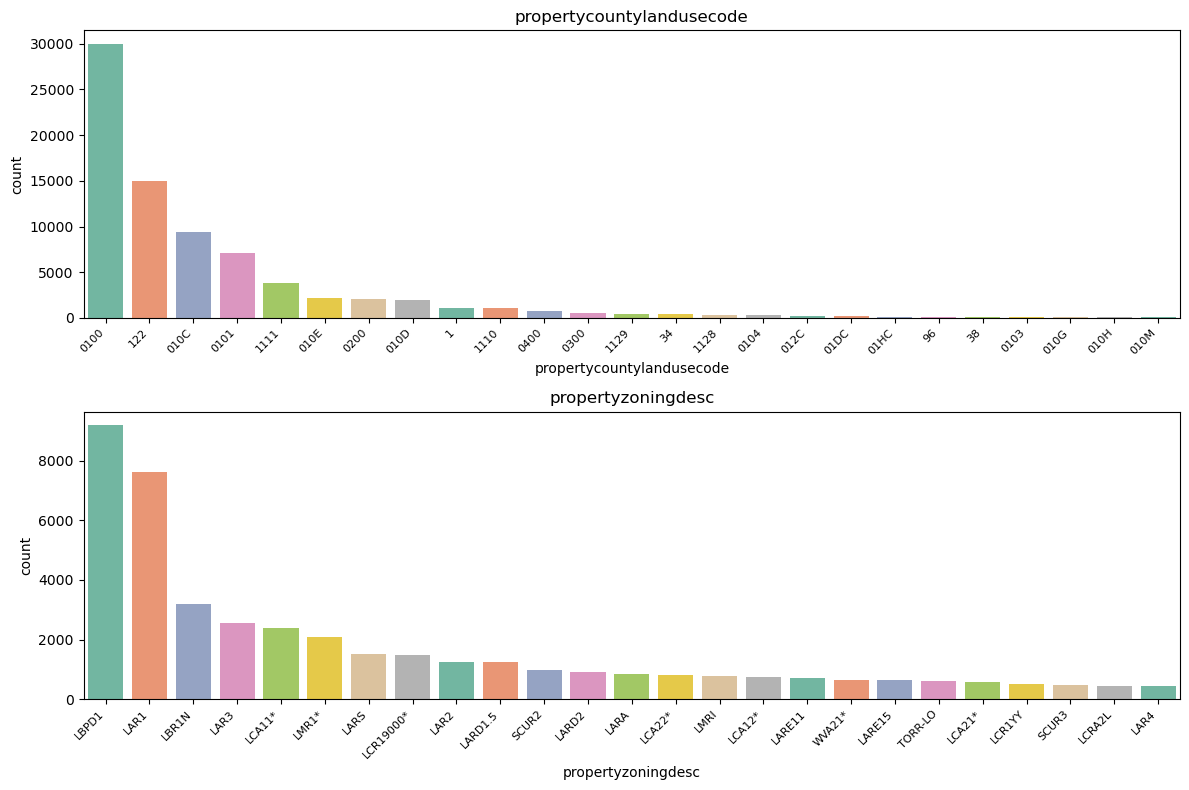

In [105]:
# Showing only the top 25 for each categorical feature
cat_features = df_cat.columns

cols = 1
rows = math.ceil(len(cat_features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4), squeeze=False)

for ax, feature in zip(axes.flat, cat_features):
    top_25 = df_cat[feature].value_counts().nlargest(25).index
    filtered_data = df_cat[df_cat[feature].isin(top_25)]
    
    sns.countplot(ax=ax, data=filtered_data, x=feature, order=top_25, palette='Set2')
    
    if ax.legend_:
        ax.legend_.remove()
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=45, ha="right")
    ax.set_title(feature)

for ax in axes.flat[len(cat_features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### 4. Multivariate Analysis <a class="anchor" id="c4"></a>
#### 4.1 Encoding Categorical Values and Saving JSON files <a id="s41"></a>

In [107]:
df_enc = df_merged.copy()
df_enc = df_enc.drop(columns='parcelid')
df_enc = df_enc[df_enc['calculatedfinishedsquarefeet'] != 0]

# Creating encoders for categorical features and saving them as JSON files. All files prefixed with 'enc'
# contain the encoding dictionaries for each categorical feature.
for column in df_cat.columns:
    unique_values = list(df_cat[column].unique())
    globals()[f"{column}_enc"] = dict(zip(unique_values, range(len(unique_values))))

    json.dump(globals()[f"{column}_enc"], open(f'../data/interim/enc_{column}.json', 'w'))

# Replacing the values in our categorical features to our encoded values (numerical)
for column in df_cat.columns:
    df_enc[column] = df_enc[column].map(json.load(open(f'../data/interim/enc_{column}.json')))

#### 4.2 Numerical-Categorical Analysis (Correlation Analysis) <a id="s42"></a>

In [109]:
# Since these 3 features only have one value, we will drop them. 
print(df_enc.transaction_year.unique(),df_enc.assessmentyear.unique(), df_enc.pooltypeid10.unique())

feat_oneval = ['transaction_year', 'assessmentyear', 'pooltypeid10']
df_enc = df_enc.drop(columns=feat_oneval)
df_enc.head(3)

[2016] [2015.] [0.]


,logerror,transaction_month,transaction_day,transaction_dayofweek,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,lat_scaled,long_scaled,regionidcity_scaled,regionidcountry_scaled,fips_scaled
0,0.0276,1,1,4,1.0,0.0,2.0,3.0,4.0,2.0,0.0,0.0,1684.0,1684.0,0.0,0.0,0.0,0.0,6037.0,0.0,2.0,0.0,0.0,0,2.0,34.280990,-118.488536,7528.0,0.0,0.0,0.0,0.0,0,261.0,0,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,0.0,1.0,0.0,0.0,1959.0,0.0,0,122754.0,360170.0,237416.0,6735.88,0,0.0,60371066461001,1.148492,-0.829967,-0.444460,0.673213,-0.545234
1,-0.1684,1,1,4,0.0,0.0,3.5,4.0,4.0,3.5,0.0,0.0,2263.0,2263.0,0.0,0.0,0.0,0.0,6059.0,0.0,3.0,2.0,468.0,0,0.0,33.668120,-117.677556,3643.0,0.0,0.0,0.0,0.0,1,261.0,1,6.059052e+07,32380.0,1286.0,403197.0,96962.0,0.0,1.0,0.0,0.0,0.0,2014.0,0.0,0,346458.0,585529.0,239071.0,10153.02,0,0.0,60590524225022,-1.369657,1.518541,-0.051517,-1.629879,0.542110
2,-0.0040,1,1,4,1.0,0.0,3.0,2.0,4.0,3.0,0.0,0.0,2217.0,2217.0,0.0,0.0,0.0,0.0,6037.0,0.0,3.0,0.0,0.0,0,2.0,34.136312,-118.175032,11423.0,0.0,0.0,0.0,0.0,0,261.0,2,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,0.0,1.0,0.0,0.0,1940.0,0.0,0,61994.0,119906.0,57912.0,11484.48,0,0.0,60374638003004,0.554042,0.077906,0.237064,0.673213,-0.545234


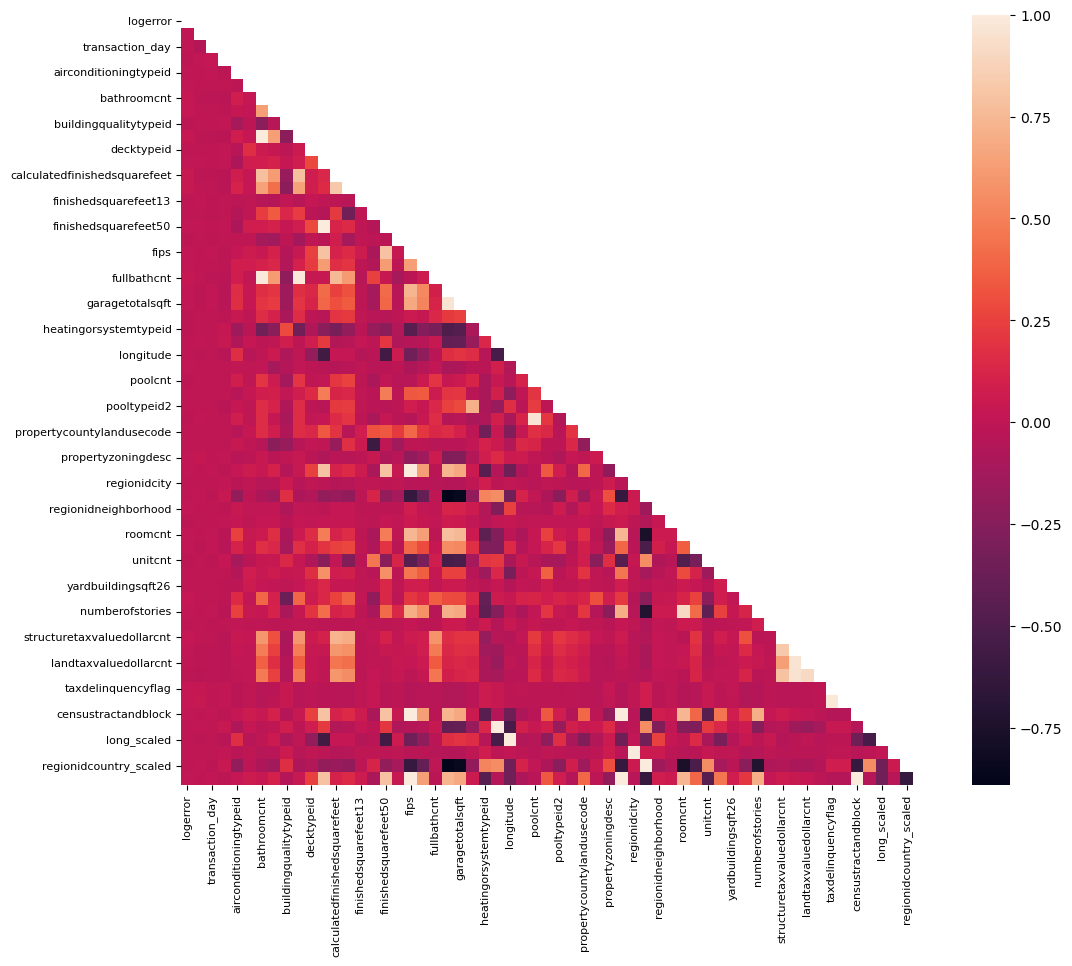

In [110]:
plt.figure(figsize=(12,10))
sns.heatmap(df_enc.corr().round(2), mask=np.triu(df_enc.corr()))
plt.yticks(fontsize=8, fontweight='light')
plt.xticks(fontsize=8, fontweight='light')
plt.show()

### 5. Feature Engineering <a class="anchor" id="c5"></a>
#### 5.1 New feature Inference <a id="s51"></a>

In [112]:
# Relationship between no. of bathrooms vs no. of bedrooms
df_enc['bath_bed_ratio'] = np.where(df_enc['bedroomcnt']==0, 0, df_enc['bathroomcnt'] / df_enc['bedroomcnt'])

# Total area being sold 
df_enc['total_area'] = df_enc['calculatedfinishedsquarefeet'] + df_enc['lotsizesquarefeet']

# Unused area being sold 
df_enc['unused_lot_space'] = df_enc['lotsizesquarefeet'] - df_enc['calculatedfinishedsquarefeet']

# Property age
df_enc['property_age'] = 2017 - df_enc['yearbuilt']

# Distance to LA city center
def distance_to_la(lat, lon):
    la_lat, la_lon = 34.0500, -118.2500

    lat_dist = abs(lat - la_lat)
    lon_dist = abs(lon - la_lon)

    dist = round(lat_dist + lon_dist,5)
    return dist 

df_enc['distantce_to_la'] = df_enc.apply(lambda row: distance_to_la(row['latitude'], row['longitude']), axis=1)

# Price per square feet
df_enc['price_per_sqft'] = df_enc['taxvaluedollarcnt'] / df_enc['calculatedfinishedsquarefeet']

# Lot size ratio
df_enc['lot_sqft_ratio'] = df_enc['lotsizesquarefeet'] / df_enc['calculatedfinishedsquarefeet']

#### 5.2 Outlier Analysis <a id="s52"></a>

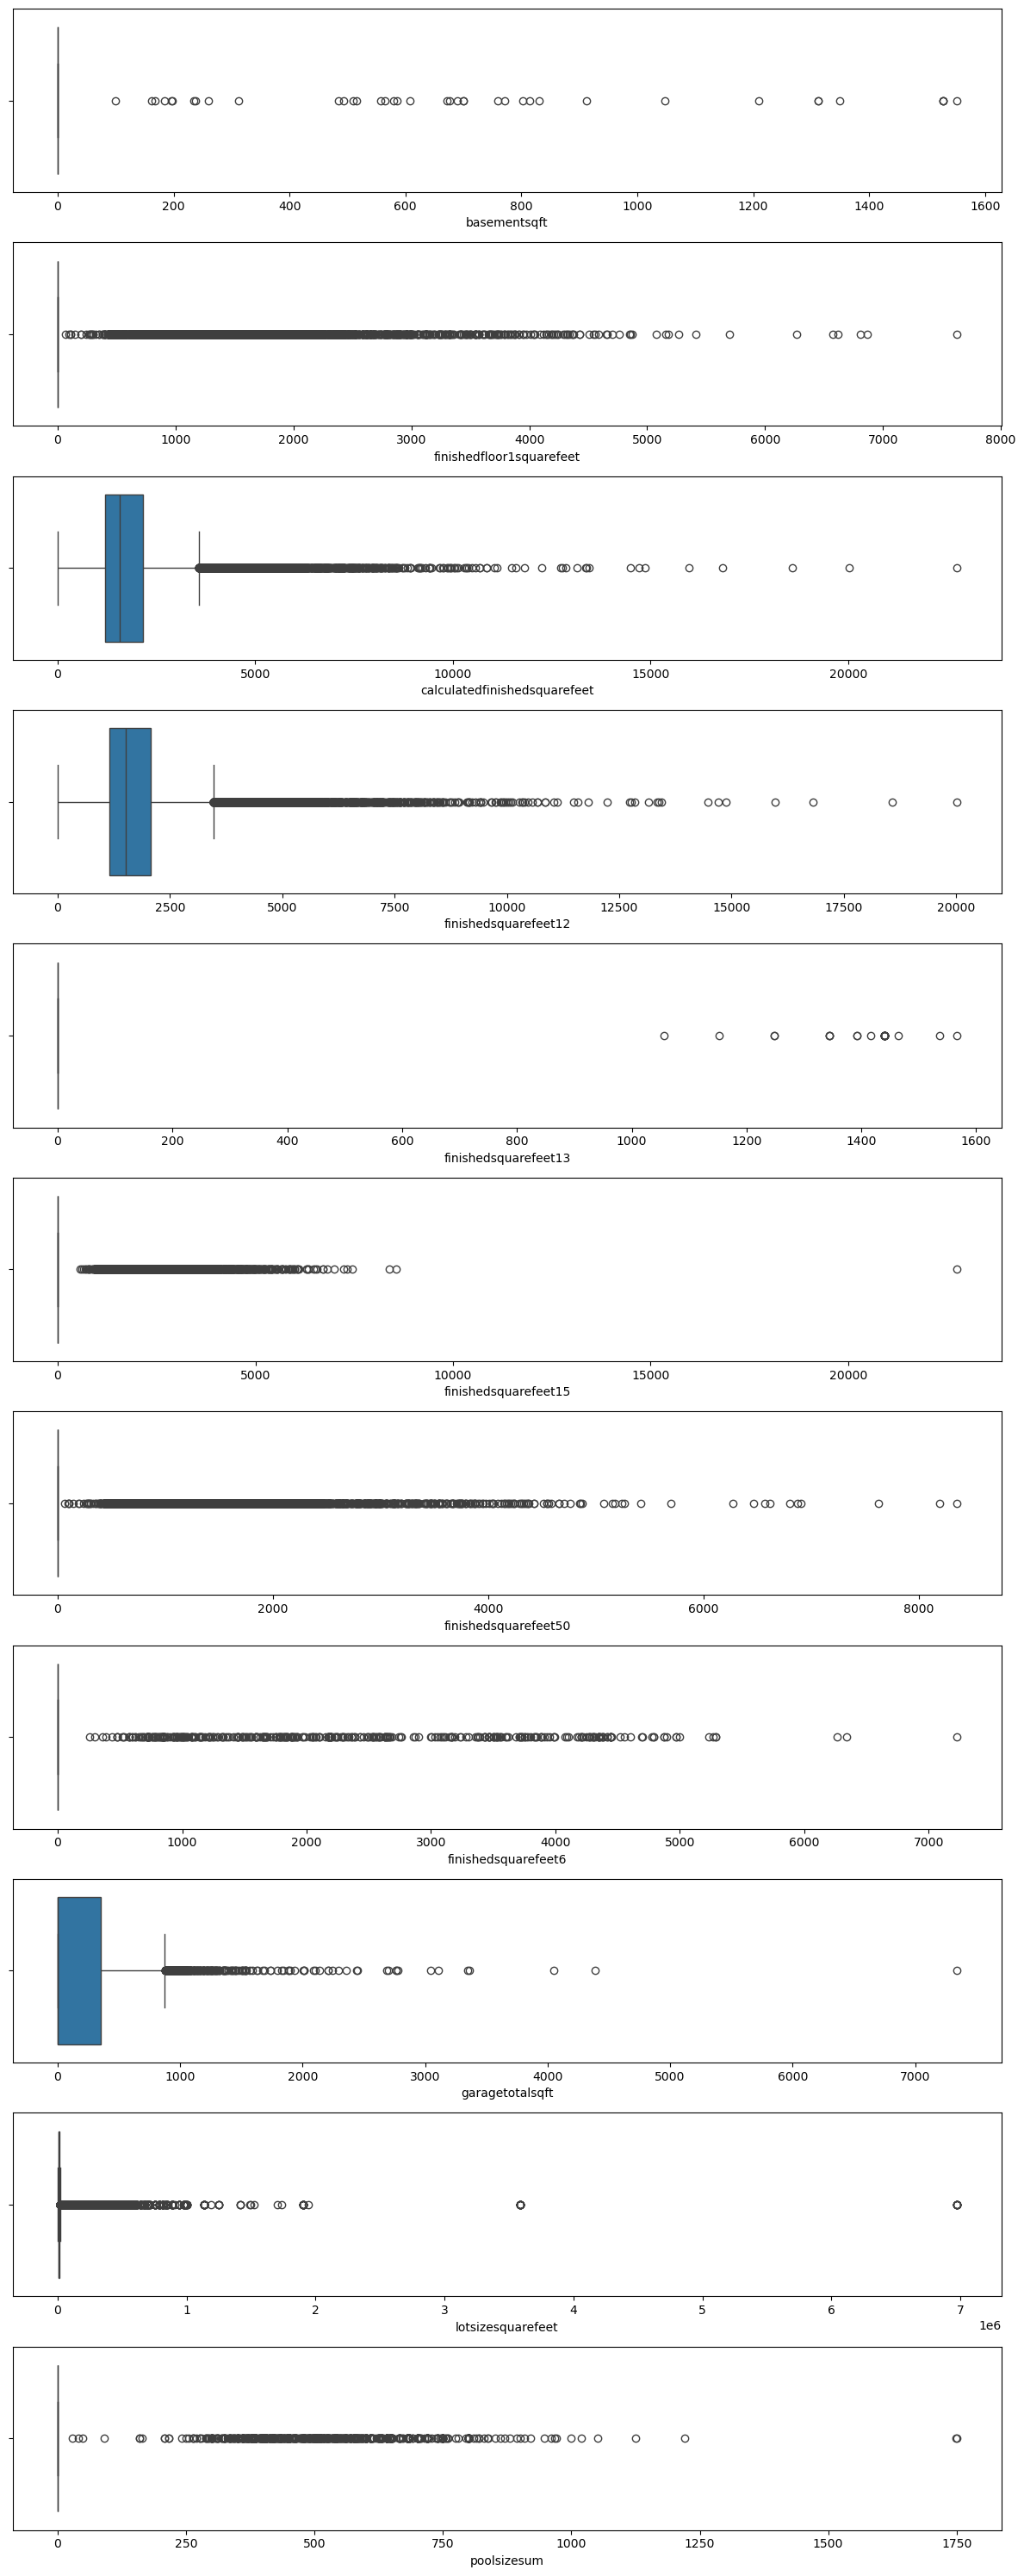

In [114]:
continuos_f = ['basementsqft', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 
               'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'garagetotalsqft', 'lotsizesquarefeet', 'poolsizesum']

fig, ax = plt.subplots(11, figsize=(12, 30))

row=0
for each in continuos_f:
    sns.boxplot(ax = ax[row], data = df_enc, x=each)
    row += 1
    
plt.tight_layout()
plt.show()

In [115]:
# # Creating a copy of our df to remove outliers 
df_enc_no = df_enc.copy()

# # This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [116]:
f_outliers_with_neg = []
f_outliers_no_neg = []

for each in continuos_f:
    if df_enc[each].min() < 0:
        f_outliers_with_neg.append(each)
    f_outliers_no_neg.append(each)

for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

In [117]:
df_enc.head(3)

,logerror,transaction_month,transaction_day,transaction_dayofweek,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,lat_scaled,long_scaled,regionidcity_scaled,regionidcountry_scaled,fips_scaled,bath_bed_ratio,total_area,unused_lot_space,property_age,distantce_to_la,price_per_sqft,lot_sqft_ratio
0,0.0276,1,1,4,1.0,0.0,2.0,3.0,4.0,2.0,0.0,0.0,1684.0,1684.0,0.0,0.0,0.0,0.0,6037.0,0.0,2.0,0.0,0.0,0,2.0,34.280990,-118.488536,7528.0,0.0,0.0,0.0,0.0,0,261.0,0,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,0.0,1.0,0.0,0.0,1959.0,0.0,0,122754.0,360170.0,237416.0,6735.88,0,0.0,60371066461001,1.148492,-0.829967,-0.444460,0.673213,-0.545234,0.666667,9212.0,5844.0,58.0,0.46953,213.877672,4.470309
1,-0.1684,1,1,4,0.0,0.0,3.5,4.0,4.0,3.5,0.0,0.0,2263.0,2263.0,0.0,0.0,0.0,0.0,6059.0,0.0,3.0,2.0,468.0,0,0.0,33.668120,-117.677556,3643.0,0.0,0.0,0.0,0.0,1,261.0,1,6.059052e+07,32380.0,1286.0,403197.0,96962.0,0.0,1.0,0.0,0.0,0.0,2014.0,0.0,0,346458.0,585529.0,239071.0,10153.02,0,0.0,60590524225022,-1.369657,1.518541,-0.051517,-1.629879,0.542110,0.875000,5906.0,1380.0,3.0,0.95432,258.740168,1.609810
2,-0.0040,1,1,4,1.0,0.0,3.0,2.0,4.0,3.0,0.0,0.0,2217.0,2217.0,0.0,0.0,0.0,0.0,6037.0,0.0,3.0,0.0,0.0,0,2.0,34.136312,-118.175032,11423.0,0.0,0.0,0.0,0.0,0,261.0,2,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,0.0,1.0,0.0,0.0,1940.0,0.0,0,61994.0,119906.0,57912.0,11484.48,0,0.0,60374638003004,0.554042,0.077906,0.237064,0.673213,-0.545234,1.500000,13640.0,9206.0,77.0,0.16128,54.084799,5.152458


### 6. Data Processing <a class="anchor" id="c6"></a>
#### 6.1 Feature Selection based on Importance <a id="s61"></a>

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7826
[LightGBM] [Info] Number of data points in the train set: 62427, number of used features: 66
[LightGBM] [Info] Start training from score 0.012373


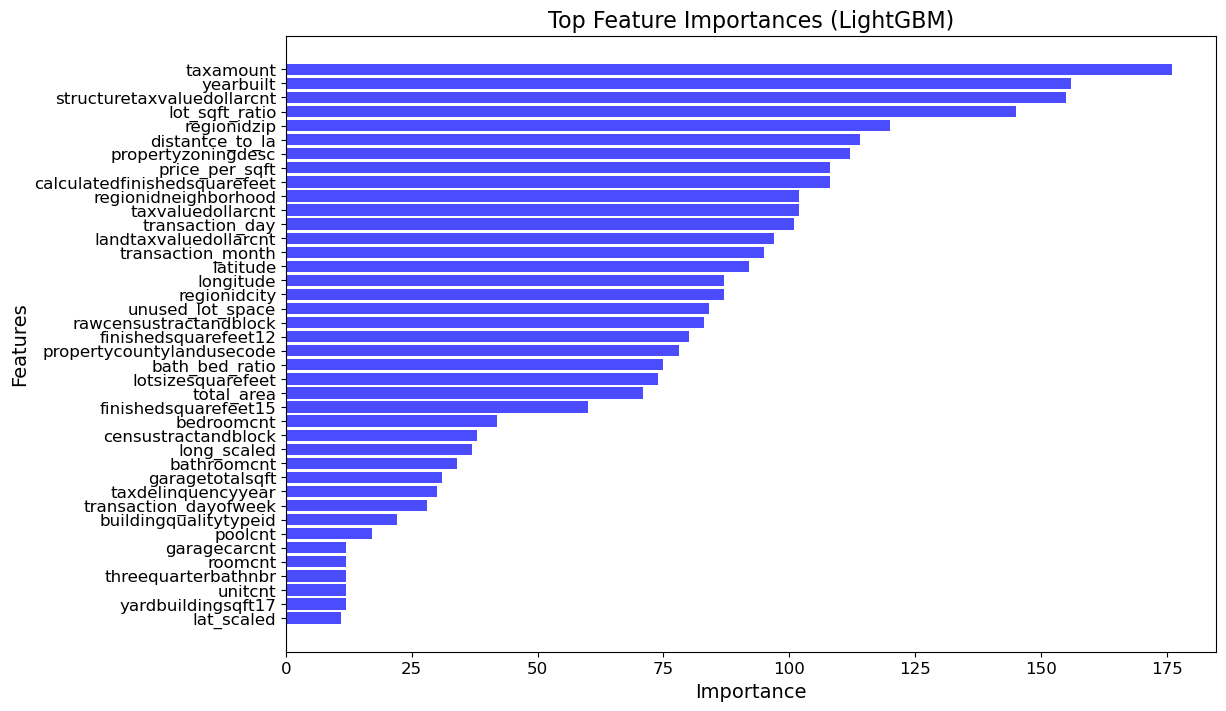

In [119]:
df_test = df_enc.copy()

X = df_test.drop(columns=['logerror']) 
y = df_test['logerror']

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Using LightGBM model to obtain feature importance
model = lgb.LGBMRegressor(random_state=123)
model.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Selecting the top most important features
top_n = 40
top_features = feature_importances.head(top_n)

# Plot the top N features
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.barh(top_features['Feature'], top_features['Importance'], color='blue', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.title('Top Feature Importances (LightGBM)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [129]:
# Define the threshold and dropping the rest 
importance_threshold = 50 
low_importance_features = feature_importances[feature_importances['Importance'] < importance_threshold]['Feature']

# Drop low-importance features
df_test = df_test.drop(columns=low_importance_features)
len(df_test.columns)

26

In [131]:
# Calculate the correlation matrix
correlation_matrix = df_test.corr()

# Find pairs of features with high correlation
threshold = 0.85
high_correlation_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
                          if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold]

print(f"Highly correlated feature pairs: {high_correlation_pairs}")

Highly correlated feature pairs: [('lotsizesquarefeet', 'total_area'), ('lotsizesquarefeet', 'unused_lot_space'), ('lotsizesquarefeet', 'lot_sqft_ratio'), ('taxvaluedollarcnt', 'landtaxvaluedollarcnt'), ('taxvaluedollarcnt', 'taxamount'), ('landtaxvaluedollarcnt', 'taxvaluedollarcnt'), ('landtaxvaluedollarcnt', 'taxamount'), ('taxamount', 'taxvaluedollarcnt'), ('taxamount', 'landtaxvaluedollarcnt'), ('total_area', 'lotsizesquarefeet'), ('total_area', 'unused_lot_space'), ('total_area', 'lot_sqft_ratio'), ('unused_lot_space', 'lotsizesquarefeet'), ('unused_lot_space', 'total_area'), ('unused_lot_space', 'lot_sqft_ratio'), ('lot_sqft_ratio', 'lotsizesquarefeet'), ('lot_sqft_ratio', 'total_area'), ('lot_sqft_ratio', 'unused_lot_space')]


In [133]:
# Drop the less important feature in each pair -> highly correlated features pairs are being dropped, to keep only one. 
features_to_drop = []
for col1, col2 in high_correlation_pairs:
    if col1 not in features_to_drop and col2 not in features_to_drop:
        # Drop the less important feature
        if feature_importances[feature_importances['Feature'] == col1]['Importance'].values[0] < feature_importances[feature_importances['Feature'] == col2]['Importance'].values[0]:
            features_to_drop.append(col1)
        else:
            features_to_drop.append(col2)

# Drop the correlated features
df_test = df_test.drop(columns=features_to_drop)
print(f"Dropped a total of {len(features_to_drop)} highly correlated features.")

Dropped a total of 5 highly correlated features.


In [146]:
df_test.to_csv('../data/processed/fulleda_final.csv', index=False)

In [181]:
df_test = pd.read_csv('../data/processed/fulleda_final.csv')

#### 6.2 Split train/test <a id="s62"></a>

In [185]:
# Split the processed data 
X = df_test.drop(columns=['logerror'])
y = df_test['logerror']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Machine Learning
#### 7.1 Decision Making: Which is the best model? <a id="s71"></a>

In [188]:
# Evaluating individual models and selecting the best 3 for ensembling
lgb_model = LGBMRegressor(random_state=123)
xgb_model = XGBRegressor(random_state=123)
cat_model = CatBoostRegressor(verbose=0, random_state=123)
rfr_model = RandomForestRegressor(random_state=123)

for name, model in [('LightGBM', lgb_model), ('XGBoost', xgb_model), ('CatBoost', cat_model), ('RandomForest', rfr_model)]:
    model.fit(X_train, y_train)
    y_pred_individual = model.predict(X_test)
    mae_individual = mean_absolute_error(y_test, y_pred_individual)
    print(f"MAE of {name}: {mae_individual:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4009
[LightGBM] [Info] Number of data points in the train set: 62427, number of used features: 20
[LightGBM] [Info] Start training from score 0.011843
MAE of LightGBM: 0.0731
MAE of XGBoost: 0.0771
MAE of CatBoost: 0.0737
MAE of RandomForest: 0.0772


In [163]:
# Ensemble model (default) -> best individual models where LightGBM, XGBoost & CatBoost 
ensemble_model = VotingRegressor(estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('cat', cat_model)])
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE of the ensemble model: {mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4009
[LightGBM] [Info] Number of data points in the train set: 62427, number of used features: 20
[LightGBM] [Info] Start training from score 0.011843
MAE of the ensemble model: 0.0736


#### 7.2 Model Optimization <a id="s72"></a> 
We will try with both LightGBM and Ensemble model, to see which was has the best MAE. 
##### 7.2.1 LightGBM Opmitization <a id="s721"></a>

In [ ]:
lgb_param_grid = {
    'num_leaves': [30, 50, 70, 100],         
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [-1, 10, 20],          
    'min_child_samples': [10, 20, 30],  
    'subsample': [0.6, 0.8, 1.0],       
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=123)

grid_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_lgb.fit(X_train, y_train)
print(f"Best parameters for LightGBM: {grid_lgb.best_params_}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 49941, number of used features: 20
[LightGBM] [Info] Start training from score 0.012152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 49941, number of used features: 20
[LightGBM] [Info] Start training from score 0.011255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set

In [189]:
# Train LightGBM with best params
model = lgb.LGBMRegressor(random_state=123, colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
                          min_child_samples=30, num_leaves=50)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4009
[LightGBM] [Info] Number of data points in the train set: 62427, number of used features: 20
[LightGBM] [Info] Start training from score 0.011843
RMSE: 0.0716


##### 7.2.2 Ensemble Optimization <a id="s722"></a>

In [591]:
# XGBoost GridSearch
xgb_param_grid = {
    'n_estimators': [100, 200, 300],        
    'learning_rate': [0.01, 0.05, 0.1],    
    'max_depth': [3, 5, 7],                
    'subsample': [0.6, 0.8, 1.0],          
    'colsample_bytree': [0.6, 0.8, 1.0],   
    'min_child_weight': [1, 5, 10],        
    'gamma': [0, 0.1, 0.2]                 
}

xgb_model = XGBRegressor(random_state=123, use_label_encoder=False, eval_metric='mae')

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {grid_xgb.best_params_}")

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best parameters for XGBoost: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}


In [80]:
# CatBoost GridSearch
cat_param_grid = {
    'iterations': [500, 1000],             # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],   # Step size for updates
    'depth': [4, 6, 8],                   # Maximum tree depth
    'l2_leaf_reg': [1, 3, 5],             # Regularization term
    'bagging_temperature': [0.1, 1, 3],   # Subsample ratio for bagging
    'border_count': [32, 64, 128]         # Number of splits for numerical features
}

cat_model = CatBoostRegressor(verbose=0, random_state=123)

grid_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    # n_jobs=-1
)

grid_cat.fit(X_train, y_train)
print(f"Best parameters for CatBoost: {grid_cat.best_params_}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters for CatBoost: {'bagging_temperature': 0.1, 'border_count': 32, 'depth': 8, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}


In [200]:
# Optimized models for the ensamble
lgb_best = lgb.LGBMRegressor(colsample_bytree=0.6, learning_rate=0.01, max_depth=10, min_child_samples=30, num_leaves=70, 
                             subsample=0.6, random_state=123)
xgb_best = XGBRegressor(colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=100,
                        subsample=0.8, random_state=123)
cat_best = CatBoostRegressor(bagging_temperature=0.1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.01, 
                             verbose=0, random_state=123)

# Ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('lgb', lgb_best),
    ('xgb', xgb_best),
    ('cat', cat_best)
])

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
print(f"MAE of Ensemble Model: {mae_ensemble:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4009
[LightGBM] [Info] Number of data points in the train set: 62427, number of used features: 20
[LightGBM] [Info] Start training from score 0.011843
MAE of Ensemble Model: 0.0715


In [202]:
pickle.dump(ensemble_model, open('../data/models/ensemble.sav', 'wb'))